In [1]:
import re
import matplotlib as mpl

import glob
import os
import shutil
import traceback
import json
import cv2
import h5py

import math
import skimage
import time

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import tifffile as tf
import _pickle as pkl
import matplotlib.colors as mcolors
import sklearn.metrics as skmetrics 
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

from skimage.color import label2rgb
#from skimage.measure import label, regionprops, find_contours
import skimage.measure as skmeasure
from skimage.measure import block_reduce

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot
import analyze2p.retinotopy.utils as retutils
import analyze2p.extraction.rois as roiutils
import analyze2p.aggregate_datasets as aggr

import analyze2p.retinotopy.segment as seg
import importlib
import analyze2p.scatter as sct

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
%matplotlib inline

## Some aggregate plotting stuff

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/retinotopy azimuth_pos_nic_Edge_LEGEND_abs
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/retinotopy elevation_pos_nic_Edge_LEGEND_abs


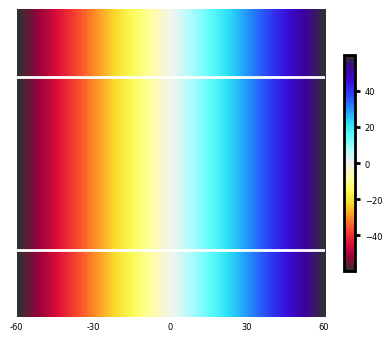

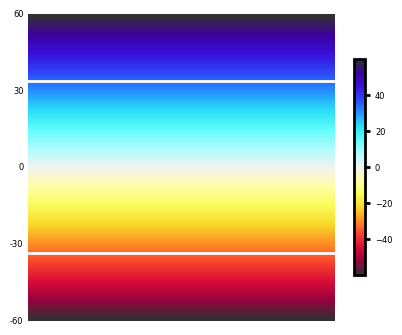

In [4]:
visual_areas, area_colors = pplot.set_threecolor_palette()
dpi = pplot.set_plot_params(lw_axes=2)
# # Load colormap
cmap_name = 'nic_Edge'
# zero_center = True
screen, cmap_phase = retutils.get_retino_legends(cmap_name=cmap_name, 
    dst_dir='/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/retinotopy',
    cmap_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/colormaps',
   zero_center=True, 
   return_cmap=True)

# Set output dirs

In [5]:
#rootdir = '/n/coxfs01/2p-data'
#aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
aggr_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data'
aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

## Find existing segmentation files

In [6]:
# from stat import S_ISREG, ST_CTIME, ST_MODE
# import os, sys, time
from datetime import datetime

In [7]:
os.listdir('/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC091/20190621')

['tmp_spids',
 '20190621_JC091_session_notes.txt',
 'motion_filter_details.json',
 'registration_figures',
 'all_paradigm_files',
 'FOV1_zoom4p0x']

In [8]:
found_assignments = glob.glob(os.path.join(rootdir, 'JC*', '20*', 'FOV*', 'retino*', 
                       'retino_analysis', 'segmentation', 'roi_assignments.json')) 

In [9]:
def sort_files_by_modified_time(file_paths):
    # Sort files by their last modified time
    sorted_files = sorted(file_paths, key=lambda x: os.path.getmtime(x), reverse=True)
    
    for file in sorted_files:
        mod_time = os.path.getmtime(file)
        readable_time = datetime.fromtimestamp(mod_time).strftime('%Y-%m-%d, %H:%M:%S')
        print(f"{file}: Last modified on {readable_time}")

In [11]:
sort_files_by_modified_time(found_assignments)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation/roi_assignments.json: Last modified on 2024-12-02, 19:28:28
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC097/20190618/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation/roi_assignments.json: Last modified on 2024-12-02, 19:19:03
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation/roi_assignments.json: Last modified on 2024-12-02, 19:12:01
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation/roi_assignments.json: Last modified on 2024-12-02, 16:36:05
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation/roi_assignments.json: Last modified on 2024-05-20, 14:51:25
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/retino_run1/retino_an

# Metadata

In [33]:
# Get all data sets
traceid='traces001'

sdata = aggr.get_aggregate_info(traceid=traceid,
                               rootdir=rootdir, aggregate_dir=aggr_dir) #, fov_type=fov_type, state=state)
retinodata = sdata[sdata['experiment']=='retino'].copy()
retinodata.groupby(['visual_area']).count()

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl


,experiment,datakey,fov,animalid,session,fovnum
visual_area,,,,,,
Li,26,26,26,26,26,26
Lm,21,21,21,21,21,21
V1,22,22,22,22,22,22


In [34]:
# screen info
screen = hutils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max
screen

{'azimuth_deg': 119.5564,
 'altitude_deg': 67.323,
 'azimuth_cm': 103.0,
 'altitude_cm': 58.0,
 'resolution': [1920, 1080],
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106)}

# Do one at a time

In [14]:
cmap_name = 'nic_Edge'
#rootdir = '/n/coxfs01/2p-data'
#aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# Map filtering params
pix_mag_thr=0.001
delay_map_thr=3

# Smoothing params
# Marhsel et al 2014 (25um sigma)
# For some reson fill_and_smooth_nans_missing() fails if too covered
# smooth spline:  make 2 if >1 area
smooth_spline=1 
target_sigma_um=25 # 
start_with_transformed=True
use_phase_smooth=False

# Segmenting params
sign_map_thr = 0.1
min_region_area = 2000

absolute_S_thr=False
close_k = 91
open_k = 151
dilate_k =31 

reprocess=True
resmooth=True
interactive=True

In [15]:
# retinodata[retinodata['animalid'].isin(new_animals)].sort_values(by=['animalid', 'session'])

# Pick dataset

In [35]:
# datakey = '20190617_JC099_fov1' 
# datakey = '20191006_JC110_fov1' #- all V1
# datakey = '20190627_JC091_fov1' - confirmed
# datakey = '20190508_JC083_fov1' - confirmed
# datakey = '20190618_JC097_fov1' - confirmed
# datakey = '20190506_JC080_fov1' - all LM
# datakey = '20190609_JC099_fov1' 
# datakey = '20190509_JC078_fov1' - confirmed
# datakey = '20190612_JC099_fov1' - fine
#'20190622_JC085_fov1' 20190315_JC070_FOV3_zoom2p0x_retino_run1
#datakey = '20190327_JC073_fov1'
datakey = '20191012_JC113_fov2'

session, animalid, fovn = hutils.split_datakey_str(datakey)
fov = 'FOV%i_zoom2p0x' % fovn
traceid = 'traces001'
# Get retino runs
found_retinoruns = [os.path.split(d)[-1] for d in 
                    glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))]
print("Found %i runs" % len(found_retinoruns))
retinorun = found_retinoruns[-1]
print(retinorun)

Found 1 runs
retino_run1


In [36]:
retinorun = sct.get_best_retinorun(datakey, rootdir=rootdir)
print(retinorun)

retino_run1


## Run step by step

In [37]:
# Get retino runs
fovnum = int(fov.split('_')[0][3:])
datakey='%s_%s_fov%i' % (session, animalid, fovnum)
data_id = '%s_%s_fov%i' % (session, animalid, int(fov.split('_')[0][3:]))

# Set current animal's retino output dir
run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
curr_dst_dir = os.path.join(run_dir, 'retino_analysis', 'segmentation')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
    print("Saving output to:\n %s" % curr_dst_dir)
# Params for processing/smoothing
processedparams_fpath = os.path.join(curr_dst_dir, 'processing_params.json')

# seg.smooth_processed_maps()

#### Get processed maps

Current run: retino_run1
DATA ID: 20190627_JC091_fov1_retino_run1_analysis001
Original dims: [512, 512]
Data were downsampled by 2.
63546 non-nan of 65536 (thr=0.001)
64065 non-nan of 65536 (thr=0.001)
64140 non-nan of 65536 (thr=0.001)
64192 non-nan of 65536 (thr=0.001)


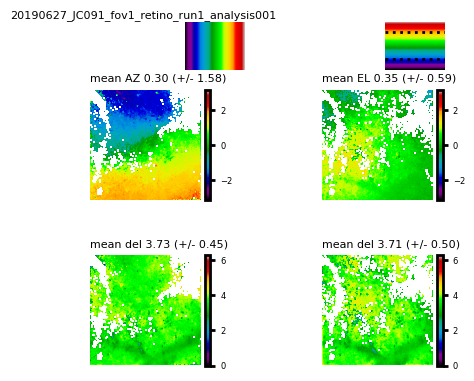

In [285]:
pix_mag_thr=0.001
delay_map_thr=2
pmaps, pparams = seg.get_processed_maps(datakey, retinorun=retinorun,
                                    pix_mag_thr=pix_mag_thr, delay_map_thr=delay_map_thr,
                                    create_new=True, rootdir=rootdir)
curr_dst_dir = os.path.join(rootdir, animalid, session, fov, retinorun, 
                            'retino_analysis', 'segmentation')
# data_id = '%s_%s_fov%i' % (session, animalid, int(fov.split('_')[0][3:]))

filt_az = pmaps['filtered_az']
filt_el = pmaps['filtered_el']
filt_azim_r = pmaps['filtered_az_scaled']
filt_elev_r = pmaps['filtered_el_scaled']
ds_factor = pparams['ds_factor']
delay_map_thr = pparams['delay_map_thr']
pix_mag_thr = pparams['pixel_mag_thr']
smooth_type = 'phasenan'if use_phase_smooth else 'gaussian'

In [286]:
list(pmaps.keys())

['absolute_az',
 'absolute_el',
 'filtered_az',
 'filtered_el',
 'filtered_az_scaled',
 'filtered_el_scaled']

#### Filter where delay map is not uniform (Az v El)

In [287]:
%matplotlib inline

<IPython.core.display.Javascript object>


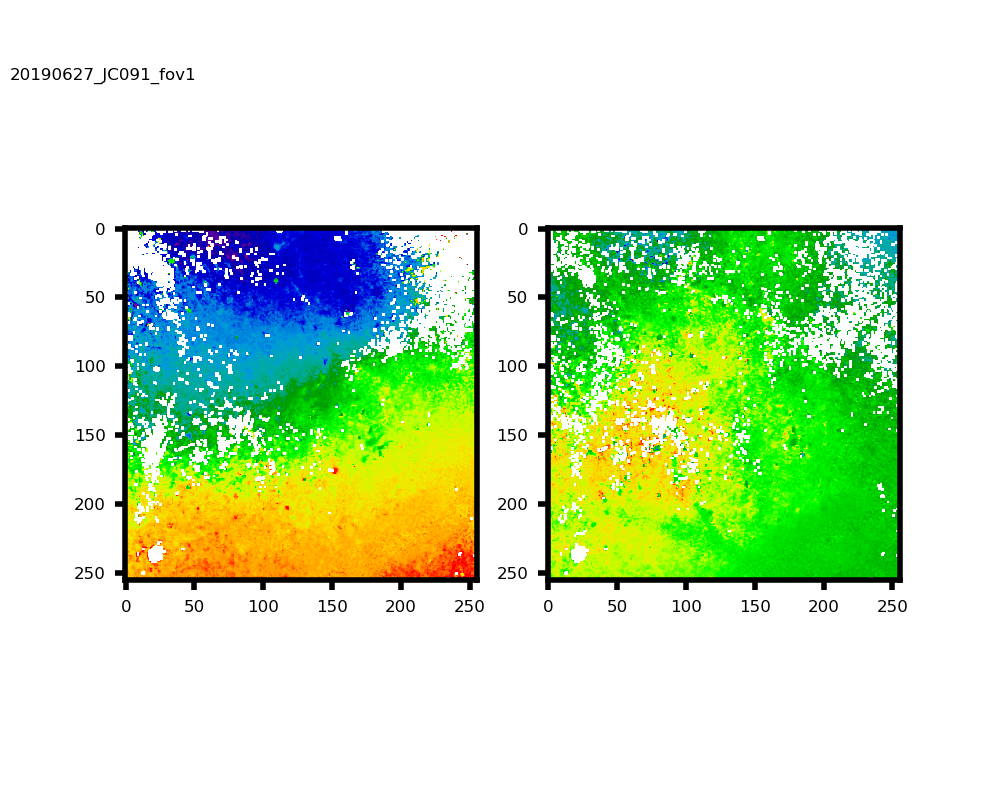

Text(0.01, 0.9, '20190627_JC091_fov1')

In [288]:
# Transform FOV to match widefield
%matplotlib notebook
f, axn = pl.subplots(1,2)
# axn[0].imshow(filt_azim_r, cmap='nipy_spectral')
# axn[1].imshow(filt_elev_r, cmap='nipy_spectral')
axn[0].imshow(pmaps['filtered_az'], cmap='nipy_spectral')
axn[1].imshow(pmaps['filtered_el'], cmap='nipy_spectral')
f.text(0.01, 0.9, datakey)

#### Smooth

In [289]:
%matplotlib inline

In [290]:
# ---------------
smooth_spline_x=1
smooth_spline_y=1
target_sigma_um=5 #35
smooth_spline = (smooth_spline_x, smooth_spline_y)
start_with_transformed=True
use_phase_smooth = False
fill_nans=True
# -------------------------
smooth_type = 'phasenan'if use_phase_smooth else 'gaussian'
# #### Smooth
start_az = filt_azim_r.copy() if start_with_transformed else filt_az.copy()
start_el = filt_elev_r.copy() if start_with_transformed else filt_el.copy()
# Get smooth sparams
pixel_size = hutils.get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
um_per_pix = np.mean(pixel_size) if start_with_transformed else np.mean(pixel_size_ds)
smooth_fwhm = int(round(target_sigma_um/um_per_pix))  # int(25*pix_per_deg) #11
print(um_per_pix, smooth_fwhm)
sm_azim, sm_elev = seg.smooth_maps(start_az, start_el, target_sigma_um=target_sigma_um, #smooth_fwhm=smooth_fwhm, 
                            smooth_spline=smooth_spline, fill_nans=fill_nans,
                            smooth_spline_x=smooth_spline_x, smooth_spline_y=smooth_spline_y,
                            start_with_transformed=start_with_transformed, 
                            use_phase_smooth=use_phase_smooth, ds_factor=ds_factor)
az_fill = sm_azim['final']
el_fill = sm_elev['final']

2.0999999999999996 2
Target: 5 (fwhm=2, k=(1, 1))
start -2.75915946776284 2.596744867733528
smoothed -2.6731585754383955 2.5967448677335283


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1157: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


fillnan -2.6731585754383955 2.3095343804003527
fillnan -2.6731585754383955 2.3095343804003527


In [291]:
# importlib.reload(seg)
# %matplotlib notebook

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation pixelmaps_smooth-2_magthr-0.001_delaymapthr-2.00


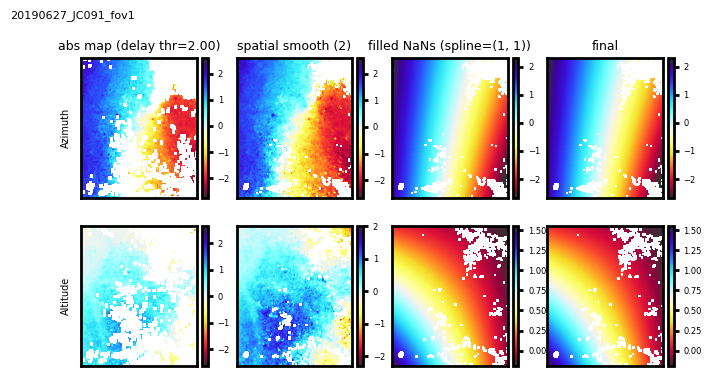

In [292]:
%matplotlib inline
vmin, vmax = (-np.pi, np.pi)
fig = seg.plot_processing_steps_pixels(
            start_az, sm_azim['smoothed'], sm_azim['nan_filled'], sm_azim['final'], 
            start_el, sm_elev['smoothed'], sm_elev['nan_filled'], sm_elev['final'],
            cmap_phase=cmap_phase, vmin=vmin, vmax=vmax, \
            smooth_fwhm=smooth_fwhm, 
            smooth_spline=(smooth_spline_x, smooth_spline_y),
            delay_map_thr=delay_map_thr, 
            full_cmap_range=False, show_cbar=True)
pplot.label_figure(fig, data_id)        
figname = 'pixelmaps_smooth-%i_magthr-%.3f_delaymapthr-%.2f' % (smooth_fwhm, pix_mag_thr, delay_map_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)
# Save 
smoothedmaps_fpath = os.path.join(curr_dst_dir, 'smoothed_maps.npz')
np.savez(smoothedmaps_fpath,
         start_az=start_az, start_el=start_el,
         azimuth=sm_azim['final'], elevation=sm_elev['final'])
smoothparams = {'smooth_fwhm': smooth_fwhm, 
                'smooth_spline': (smooth_spline_x, smooth_spline_y),
                'target_sigma_um': target_sigma_um, 
                'start_with_transformed': start_with_transformed,
                'use_phase_smooth': use_phase_smooth,
                'smooth_type': smooth_type}
pparams.update(smoothparams)
# Save
results_dir = glob.glob(os.path.join(rootdir, animalid, session, fov,
                    retinorun, 'retino_analysis', 'segmentation'))
processingparams_fpath = os.path.join(results_dir[0], 'processing_params.json')
with open(processedparams_fpath, 'w') as f:
    json.dump(pparams, f, indent=4)

## Get surface img

<IPython.core.display.Javascript object>


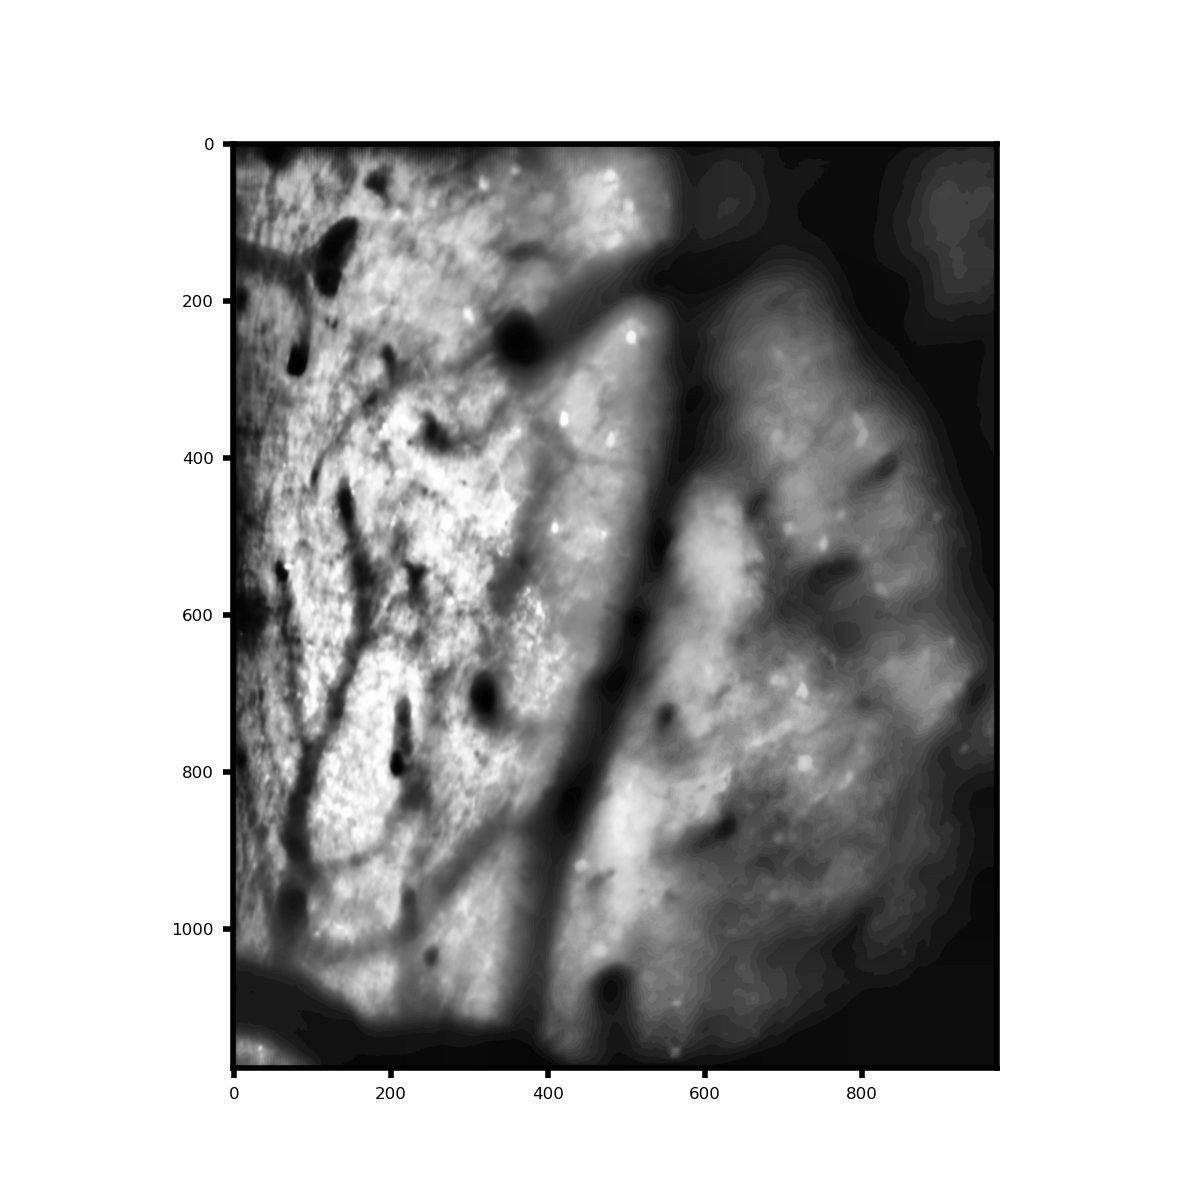

NameError: name 'az_fill' is not defined

In [38]:
#### Get surface img
surface_img = retutils.load_2p_surface(datakey, ch_num=1, retinorun=retinorun,
                                      rootdir=rootdir)
pixel_size = hutils.get_pixel_size()
surface_2p = retutils.transform_2p_fov(surface_img, pixel_size, normalize=False)
surface_2p = pplot.adjust_image_contrast(surface_2p, clip_limit=10.0, tile_size=5)
fig, ax = pl.subplots(figsize=(6,6))
ax.imshow(surface_2p, cmap='gray')
#### Convert to screen units
vmin, vmax = (-np.pi, np.pi)
img_az = hutils.convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = hutils.convert_range(el_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)   

# Segement areas

In [294]:
%matplotlib inline

smoothing


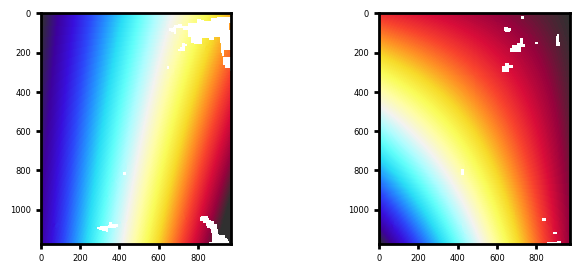

In [295]:
# Segmenting params
sign_map_thr = 0.1
min_region_area = 5000 #2000
# -------------------------------------------------------------------
# Create sign map 
if target_sigma_um <= 5:
    print("smoothing")
    img_az2 = retutils.smooth_neuropil(img_az, smooth_fwhm=3)
    img_el2 = retutils.smooth_neuropil(img_el, smooth_fwhm=3)

    O, S_thr = seg.segment_areas(img_az2, img_el2, sign_map_thr=sign_map_thr)
    fig, ax =pl.subplots(1,2, figsize=(8,3))
    ax[0].imshow(img_az2, cmap=cmap_phase)
    ax[1].imshow(img_el2, cmap=cmap_phase)
else:
    O, S_thr = seg.segment_areas(img_az, img_el, sign_map_thr=sign_map_thr)

In [296]:
importlib.reload(seg)
%matplotlib notebook

Text(0.01, 0.9, '20190627_JC091_fov1')

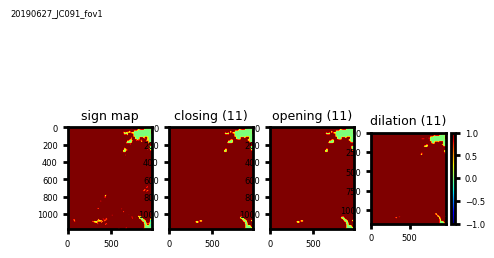

In [297]:
%matplotlib inline
absolute_S_thr=False

close_k = 11
open_k = 11
dilate_k = 11

#S=S_thr.copy() #np.sign(O) # Discretize into patches
S = abs(S_thr) if absolute_S_thr else S_thr.copy()
S[np.isnan(O)]=0

# Morphological steps
S, closing_s1, opening_s1, dilation = seg.do_morphological_steps(S,
                                            close_k=close_k, open_k=open_k, dilate_k=dilate_k)

sfig = seg.plot_morphological_steps(S, closing_s1, opening_s1, dilation, 
                                            close_k=close_k, open_k=open_k, dilate_k=dilate_k) 

sfig.text(0.01, 0.9, datakey)

In [298]:
datakey

'20190627_JC091_fov1'

# Test w/ morphological steps


#### Update segmentation params

In [299]:
# #### Update segmentation params
seg_params = pparams.copy()
seg_params.update({'morphological_kernels': (close_k, open_k, dilate_k),
                   'absolute_S_thr': absolute_S_thr,
                   'sign_map_thr': sign_map_thr,
                   'min_region_area': min_region_area})

(1177, 972) (1177, 972, 3)
Found 1 regions: [1]


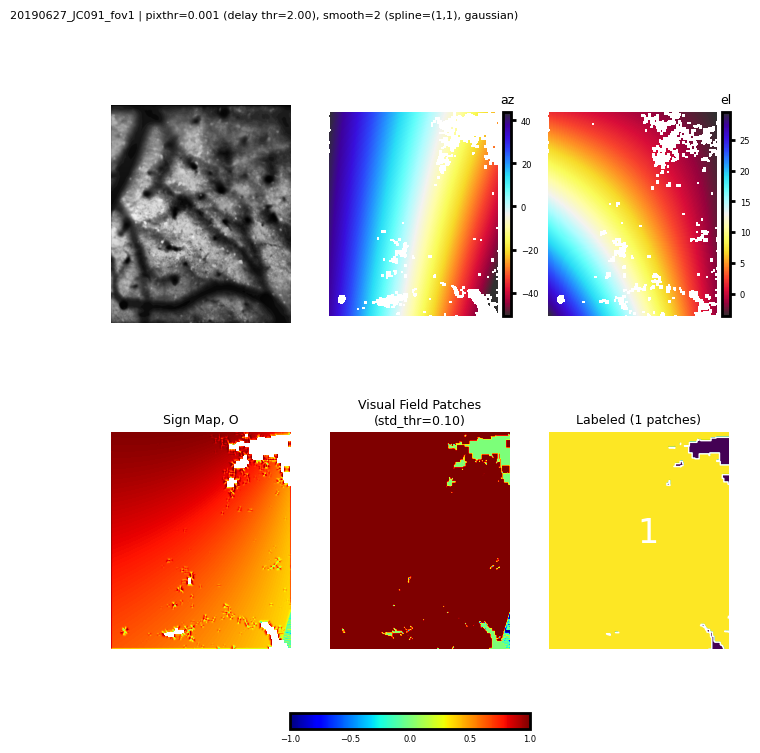

In [300]:
#### Label image
region_props, labeled_image  = seg.segment_and_label(dilation, 
                                        min_region_area=min_region_area)
region_labels = [region.label for region in region_props]
print('Found %i regions: %s' % (len(region_labels), str(region_labels)))
##### Save
orig_d1, orig_d2 = surface_2p.shape
labeled_image_2p = cv2.resize(labeled_image.astype(np.uint8), (orig_d2, orig_d1))
results = {'labeled_image_ds': labeled_image, 
           'labeled_image': labeled_image_2p,
           'region_props': region_props}

##### Plot segmentation results
proc_info_str = 'pixthr=%.3f (delay thr=%.2f), smooth=%i (spline=(%i,%i), %s)' \
                    % (pix_mag_thr, delay_map_thr, smooth_fwhm, smooth_spline_x, smooth_spline_y, smooth_type)
fig = seg.plot_segmentation_steps(img_az, img_el, surface=surface_2p, O=O, S_thr=S_thr, 
                                params=seg_params, cmap=cmap_phase, 
                                labeled_image=labeled_image, region_props=region_props, 
                                label_color='w')
pplot.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.subplots_adjust(hspace=0.5, bottom=0.2) 
pl.savefig(os.path.join(curr_dst_dir, 'segemented_areas.png'))
pl.show()

# Select areas and label

Lm 1117112.0


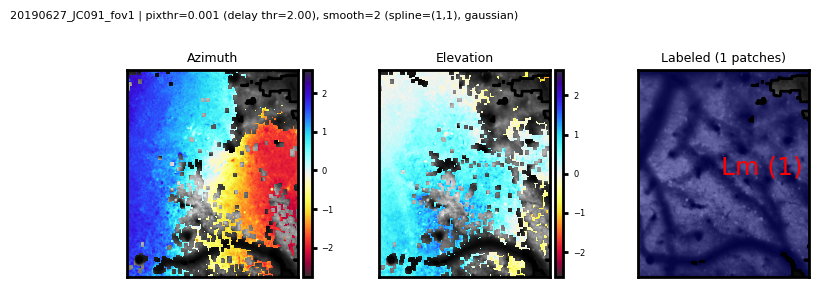

In [301]:
region_dict={1: 'Lm'} #, 2:'Li'} #, 2:'Lm'} #, 3: 'V1', 2: 'Lm'} #,5:'Lm'} #, 2: 'AL', 4: 'Li'} #V1'}
#region_dict.update(dict( (i, 'Ll') for i in [3]))

#region_dict={1: 'Lm'} #,5:'Lm'} #, 2: 'AL', 4: 'Li'} #V1'}
seg_areas = {}
for ri, region in enumerate(region_props):
    region_id = region.label
    if region.label in region_dict.keys():
        region_name = region_dict[region.label]
    else:
        region_name = region.label
    # save mask
    region_mask = np.copy(labeled_image.astype('float'))
    region_mask[labeled_image != region_id] = 0
    region_mask[labeled_image == region_id] = 1
    if region_name in seg_areas.keys():
        region_mask = seg_areas[region_name]['mask'] + region_mask # Update region mask
        region_id = seg_areas[region_name]['id']
        labeled_image[region_mask==1] = seg_areas[region_name]['id'] # Update labeled image
    seg_areas[region_name] = {'id': region_id, 'mask': region_mask}

# double check labeling/naming of segmented areas
label_keys = [(k, v['id']) for k, v in seg_areas.items() if not(hutils.isnumber(k))]
results.update({'areas': seg_areas})
results.update({'label_keys': label_keys})

# Plot results with segmented areas
pos_multiplier = (1,1) if start_with_transformed else (pixel_size[0], pixel_size[1]) 
area_ids = [k[1] for k in label_keys]
labeled_image_incl = np.ones(labeled_image.shape)*np.nan #labeled_image.copy()
for idx in area_ids:
    labeled_image_incl[labeled_image==idx] = idx

fig = seg.plot_labeled_areas(filt_azim_r, filt_elev_r, surface_2p, label_keys,
                        labeled_image_2p, labeled_image_incl,
                        region_props, cmap_phase=cmap_phase, pos_multiplier=pos_multiplier)
pl.subplots_adjust(wspace=0.3, top=0.8)
pplot.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.savefig(os.path.join(curr_dst_dir, 'labeled_areas.png'))


In [302]:
# results['region_props']

In [303]:
results.pop('region_props')
results

{'labeled_image_ds': array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 'labeled_image': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
 'areas': {'Lm': {'id': 1,
   'mask': array([[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]])}},
 'label_keys': [('Lm', 1)]}

## Save results

In [304]:
curr_dst_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation'

In [305]:
# ## Save results
segparams_fpath = os.path.join(curr_dst_dir, 'params.json')
with open(segparams_fpath, 'w') as f:
    json.dump(seg_params, f, indent=4, sort_keys=True) 
    
segresults_fpath = os.path.join(curr_dst_dir, 'results.pkl')
with open(segresults_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=2)

print("Completed segmentation!")
print(curr_dst_dir)

Completed segmentation!
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation


In [306]:
# with open(segresults_fpath, 'rb') as f:
#     test = pkl.load(f, encoding='latin1')
    

## Calculate gradient for segmented areas

In [307]:
datakey, retinorun

('20190627_JC091_fov1', 'retino_run1')

In [308]:
importlib.reload(seg)

<module 'analyze2p.retinotopy.segment' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py'>

In [309]:
seg_results, seg_params = seg.load_segmentation_results(datakey, retinorun=retinorun,
                                                       rootdir=rootdir)
segmented_areas = seg_results['areas']
# region_props = seg_results['region_props'] # Can't pkl region_props
print(segmented_areas.keys())

dict_keys(['Lm'])


In [310]:
# pmaps, pparams = seg.get_processed_maps(dk, retinorun=retinorun, create_new=False)
# ds_factor = pparams['ds_factor']
# delay_map_thr = pparams['delay_map_thr']
# pix_mag_thr = pparams['pixel_mag_thr']
# smooth_type = 'phasenan'if use_phase_smooth else 'gaussian'
# # ------------------------------------
# start_az = pmaps['filtered_az_scaled']
# start_el = pmaps['filtered_el_scaled']

# thr_img_az = start_az.copy() 
# thr_img_az[curr_segmented_mask==0] = np.nan     

# thr_img_el = start_el.copy() 
# thr_img_el[curr_segmented_mask==0] = np.nan     
# # -----------------------------------------
# smooth_spline=(1, 1)
# target_sigma_um=25 # 
# start_with_transformed=True
# use_phase_smooth=False
# fill_nans=True
# sm_azim, sm_elev = seg.smooth_maps(thr_img_az, thr_img_el, 
#                                 target_sigma_um=target_sigma_um, 
#                                 smooth_spline=smooth_spline, fill_nans=fill_nans,
#                                 start_with_transformed=start_with_transformed, 
#                                 use_phase_smooth=use_phase_smooth, 
#                                 ds_factor=ds_factor)
# az_fill = sm_azim['final']
# el_fill = sm_elev['final']

# # screen info
# screen = hutils.get_screen_dims()
# screen_max = screen['azimuth_deg']/2.
# screen_min = -screen_max

# #### Convert to screen units
# vmin, vmax = (-np.pi, np.pi)
# img_az = hutils.convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
# img_el = hutils.convert_range(el_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
# vmin, vmax = (screen_min, screen_max)   

0 Lm
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation gradients_Lm


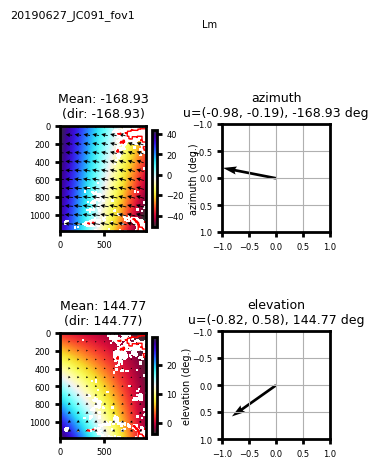

In [311]:
%matplotlib inline
contour_lc='r'
contour_lw=1
spacing =100
scale = 0.001 #0.0001
width = 0.01 #1 #0.01
headwidth=5

for vi, (curr_visual_area, area_results) in enumerate(segmented_areas.items()):
    print(vi, curr_visual_area)
    if hutils.isnumber(curr_visual_area):
        continue
    curr_segmented_mask = area_results['mask']
    grad_az, grad_el = seg.calculate_gradients(curr_segmented_mask, img_az, img_el)
    # Plot results ------------
    curr_labeled_image = np.zeros(labeled_image.shape)
    curr_labeled_image[labeled_image==area_results['id']] = 1
    fig = seg.plot_gradients_in_area(curr_labeled_image, img_az, img_el, grad_az, grad_el, cmap_phase=cmap_phase,
                                 contour_lc=contour_lc, contour_lw=contour_lw, spacing=spacing, 
                                 scale=scale, width=width, headwidth=headwidth)
    pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8)
    pplot.label_figure(fig, data_id)
    fig.suptitle(curr_visual_area)

    figname = 'gradients_%s' % curr_visual_area
    pl.savefig(os.path.join(curr_dst_dir, '%s_v2.png' % figname))
    print(curr_dst_dir, figname)

# Assign cells to visual area(s)

In [42]:
%matplotlib notebook
#### Get roi masks 
traceid= 'traces001'
roi_id = None #'rois001'
if roi_id is None:
    roi_id = roiutils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid,
                                            rootdir=rootdir)
r_masks, zprog_img = roiutils.load_roi_masks(animalid, session, fov, rois=roi_id,
                                            rootdir=rootdir)
print("Loaded rois: %s" % roi_id)
nrois, d2, d1 = r_masks.shape
##### Reshape and transform to match 'natural view'
pixel_size = hutils.get_pixel_size() #* ds_factor
roi_masks_tr = np.dstack([retutils.transform_2p_fov(\
                            r_masks[i,:,:].astype(float), pixel_size) \
                            for i in np.arange(0, nrois)]) # transform/orient
roi_masks = roi_masks_tr.astype(bool).astype(int)
print(roi_masks.shape)

Loaded rois: rois002
(1177, 972, 286)


#### Load segmentation results

In [43]:
seg_results, seg_params = seg.load_segmentation_results(datakey, retinorun=retinorun,
                                                       rootdir=rootdir)
seg_areas = seg_results['areas']

RecursionError: maximum recursion depth exceeded

#### Assign roi IDs to visual area

In [ ]:
verbose=False
create_new = False

id_cmap='colorblind'
contour_lw=1
contour_lc='w'

#return_labeled_masks=False

if not create_new:
    try:
        print("Loading roi assignments")
        roi_assignments = seg.load_roi_assignments(datakey, retinorun=retinorun,
                                                  rootdir=rootdir)
    except AssertionError:
        create_new=True

plot_rois = True
if create_new:
    print("Assigning rois to visual areas...")
    # Assign each ROI to visual areas
    roi_assignments = seg.label_roi_masks(seg_results, roi_masks)

    # Save assignments
    assignments_fpath = os.path.join(curr_dst_dir, 'roi_assignments.json')
    with open(assignments_fpath, 'w') as f:
        json.dump(roi_assignments, f, indent=4)
    create_new=False

plotting assigned rois


<IPython.core.display.Javascript object>


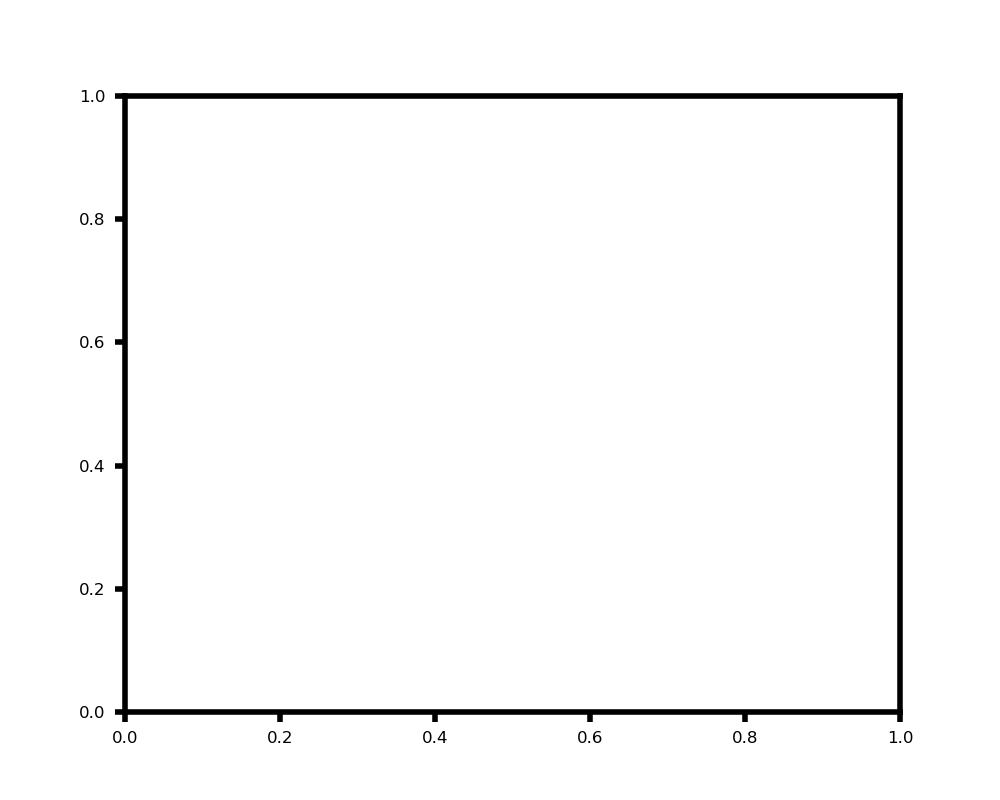

IndexError: index 286 is out of bounds for axis 2 with size 286

In [41]:

if plot_rois:
    print("plotting assigned rois")
    labeled_image = seg_results['labeled_image']
    f, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    seg.plot_labeled_rois(labeled_image, roi_assignments, roi_masks, 
                     cmap=id_cmap, surface=surface_2p, ax=ax,
                     contour_lw=contour_lw, contour_lc=contour_lc)
    pl.subplots_adjust(left=0.1, right=0.85)
    pplot.label_figure(fig, data_id)
    ax.set_title('%s\n%s' % (datakey, retinorun))
    pl.savefig(os.path.join(curr_dst_dir, 'assigned_rois.svg'))